# Packages

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

from astropy.io import fits
from scipy.ndimage import median_filter
from scipy.signal import correlate, find_peaks
from numpy.polynomial.polynomial import Polynomial
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift as nd_shift 
from scipy.signal import savgol_filter

# Image Functions

In [75]:
def load_fits_2d(path: str) -> np.ndarray:
    with fits.open(path) as hdul:
        data = hdul[0].data
    data = np.squeeze(data).astype(np.float32)
    if data.ndim != 2:
        raise ValueError(f"{path}: erwartet 2D, bekam shape {data.shape}")
    return data

def extract_1d_spectrum(data2d: np.ndarray, half_height: int = 20, bg_offset: int = 50, bg_half: int = 10, filtering = True, normalize = True):
    """
    - findet y0 über Summe entlang x (Spurmaximum)
    - extrahiert Summe im Fenster [y0-half_height, y0+half_height]
    - zieht Hintergrund ab (aus zwei Off-Trace Fenstern)
    """
    ny, nx = data2d.shape

    # Spurposition schätzen
    y_profile = np.sum(data2d, axis=1)
    y0 = int(np.argmax(y_profile))

    y1 = max(0, y0 - half_height)
    y2 = min(ny, y0 + half_height + 1)

    # Hintergrundfenster ober-/unterhalb
    yb1a = ny - bg_offset - bg_half # lower Window beginning
    yb1b = ny - bg_offset + bg_half + 1 # lower Window end
    yb2a = y0 + bg_offset - bg_half # upper Window beginning
    yb2b = y0 + bg_offset + bg_half + 1 # upper Window end

    # yb1a = max(0, y0 - bg_offset - bg_half) # lower Window beginning
    # yb1b = max(0, y0 - bg_offset + bg_half + 1) # lower Window end
    # yb2a = min(ny, y0 + bg_offset - bg_half) # upper Window beginning
    # yb2b = min(ny, y0 + bg_offset + bg_half + 1) # upper Window end


    bg_rows = []
    if yb1b > yb1a:
        bg_rows.append(data2d[yb1a:yb1b, :])
    if yb2b > yb2a:
        bg_rows.append(data2d[yb2a:yb2b, :])

    if len(bg_rows) > 0:
        bg = np.median(np.vstack(bg_rows), axis=0)  # 1D background vs x
    else:
        bg = np.zeros(nx, dtype=np.float32)

    spec = np.sum(data2d[y1:y2, :], axis=0) - (y2 - y1) * bg

    if filtering == True:
        spec = savgol_filter(spec, window_length= 31, polyorder=3)


    if normalize:

        # NaNs vermeiden
        x = np.arange(nx)
        m = np.isfinite(spec)
        spec_i = np.interp(x, x[m], spec[m])
        cont_window = 300
        # Stark glätten = Kontinuum/Response
        # cont_window muss ungerade sein
        if cont_window % 2 == 0:
            cont_window += 1

        continuum = savgol_filter(spec_i, window_length=300, polyorder=2)

        # Division
        continuum[continuum == 0] = 1
        spec = spec / continuum


    xpix = np.arange(nx, dtype=np.float32)
    return xpix, spec, y0, (y1, y2)





def stitch_spectra(specA: np.ndarray, specB: np.ndarray, shift: int):
    """
    Erzeugt combined Spectrum auf gemeinsamer Pixelachse:
    - A liegt auf x=[0..lenA-1]
    - B liegt auf x=[shift..shift+lenB-1]
    In Überlapp: Mittelwert.
    """
    lenA = len(specA)
    lenB = len(specB)

    if shift < 0:
        x1 = lenA + shift + lenB

        

        x = np.arange(0, x1)
        print(len(x))

        comb = np.zeros_like(x, dtype=np.float64)

        print(len(specB[np.abs(shift)-1:]))
        print(len(comb))
        print(len(comb[lenA:]))
        print(len(comb)- lenA, "!=",np.abs(shift))
        
        comb[0:lenA] = specA
        comb[lenA:] = specB[np.abs(shift):]
    else:
        x1 = lenA - shift + lenB

        

        x = np.arange(0, x1)
        print(len(x))

        comb = np.zeros_like(x, dtype=np.float64)
        print(len(comb))
        print(len(comb[:lenA-shift]))
        print(len(specA[:lenA-shift]))
        print(len(comb[:lenA-shift]))
        print(len(specA[:lenA-shift]))
        print(len(comb)- lenB, "!=",np.abs(shift))
    
        
        comb[0:lenA-shift] = specA[:lenA-shift]
        comb[lenA-shift:] = specB
 

    return x.astype(np.float32), comb.astype(np.float32)




## Plot Image

Filename: Astrowoche2025/1_night/Kal_2/kal_1_25/kal_1_25_after.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (1530, 1020)   int16 (rescales to uint16)   


Filename: Astrowoche2025/1_night/Kal_2/kal_0_35/kal_0_35_after.FIT
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (1530, 1020)   int16 (rescales to uint16)   


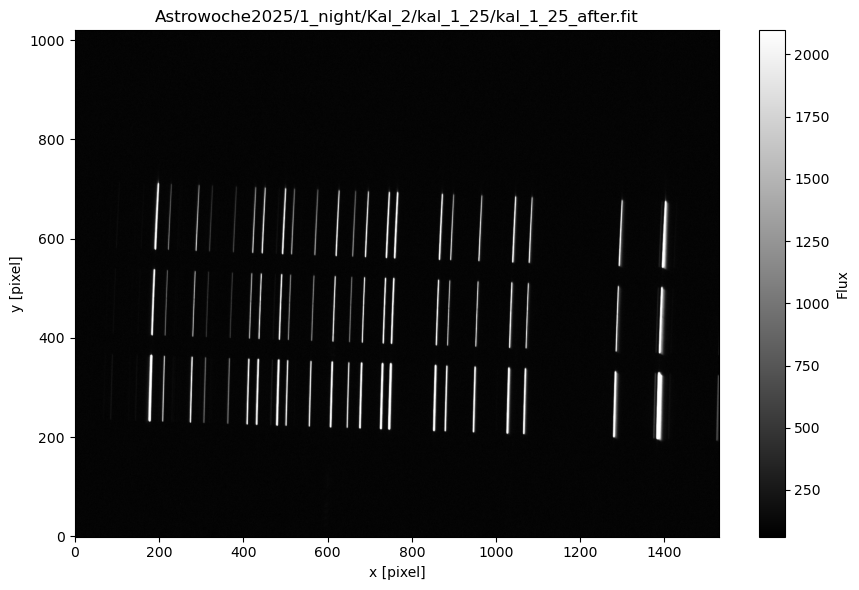

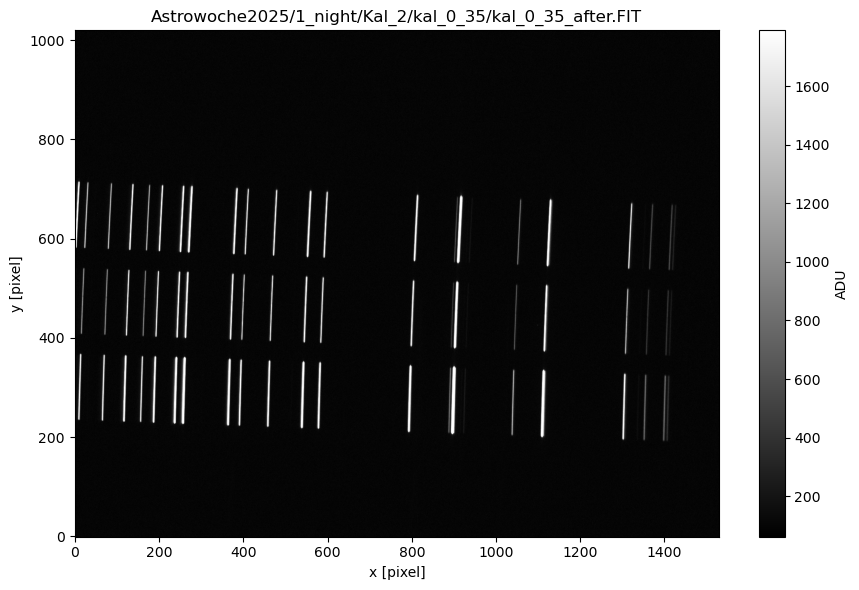

In [3]:
path1 = "Astrowoche2025/1_night/Kal_2/kal_1_25/kal_1_25_after.fit"

with fits.open(path1) as hdul:
    hdul.info()                   # zeigt genau das, was du gepostet hast
    data1 = hdul[0].data.astype(np.float32)   # wichtig: in float umwandeln
    header = hdul[0].header

path2 = "Astrowoche2025/1_night/Kal_2/kal_0_35/kal_0_35_after.FIT"


with fits.open(path2) as hdul:
    hdul.info()                   # zeigt genau das, was du gepostet hast
    data2 = hdul[0].data.astype(np.float32)   # wichtig: in float umwandeln
    header = hdul[0].header
vmin, vmax = np.percentile(data1, [1, 99])

# Image 1
plt.figure(figsize=(9,6))
plt.imshow(data1, origin="lower", cmap="gray", vmin=vmin, vmax=vmax, aspect="auto")
plt.colorbar(label="Flux")
plt.title(path1)
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.tight_layout()
plt.show()

vmin, vmax = np.percentile(data2, [1, 99])
#Image 2
plt.figure(figsize=(9,6))
plt.imshow(data2, origin="lower", cmap="gray", vmin=vmin, vmax=vmax, aspect="auto")
plt.colorbar(label="ADU")
plt.title(path2)
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.tight_layout()
plt.show()

## Estimate Shift

In [77]:
def multiple_files(folder_path, filtering = False, normalize= False):
    
    spec_all  = []


    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        img = fits.getdata(file_path)
        pixel, spec, *rest = extract_1d_spectrum(img, filtering = filtering, normalize= normalize)
        print(file_path)
        spec_all.append(spec)
        print(len(spec))
    
    spectra = np.array(spec_all)
    pixel = np.arange(spectra.shape[1])

    avg_spectra = np.median(spectra, axis = 0)
    return pixel, avg_spectra

def preprocess_1d(spec, smooth=101):
    spec = spec.astype(np.float32)

    # NaNs raus
    spec = np.nan_to_num(spec, nan=np.nanmedian(spec))

    # Kontinuum schätzen und entfernen (flattening)
    cont = median_filter(spec, size=smooth)
    cont = np.clip(cont, 1e-6, None)
    h = spec / cont
    h = h - np.median(h)

    # Normieren
    s = np.std(h)
    if s > 0:
        h /= s

    # Fenstern gegen FFT wrap-around
    w = np.hanning(len(h)).astype(np.float32)
    h *= w

    return h


def combine_spec(path1, path2, folder1 : bool = False, folder2 : bool = False, plot: bool= True, shift = None, scal = None, filtering = False, normalize = False):
    """Finds shift of image 1 in image 2 and combines the two spectras by the correpsonding shift. 

    Args:
        path1 (fits file): data of grating setting 1_25
        path2 (fits file): data of grating setting 0_35
        folder1: if path1 corresponds to a folder
        folder2: if path2 corresponds to a folder
        plot: if True, then plot will be displayed
        shift: if None, phase_cross_correlation will determine shift
        filtering: if True, extract_1d_spectrum will filter data

    Returns:
        x_comb: combined x axis
        s_comb: combined spectrum
        x1, s1: x and spectrum of grating setting 1_25
        x2, s2: x and spectrum of grating setting 0_35
        shift: determined shift between both images
    """
    # load FITS 


    if (folder1 == 1) & (folder2 == 1):
        x1, s1 = multiple_files(path1, filtering = filtering, normalize= normalize) 
        x2, s2 = multiple_files(path2, filtering = filtering,normalize= normalize) 
    elif (folder1 == 1) & (folder2 != 0):
        x1, s1 = multiple_files(path1, filtering = filtering, normalize= normalize)
        img2 = fits.getdata(path2)

        x2, s2, *rest = extract_1d_spectrum(img2, half_height=10, filtering=filtering, normalize= normalize)
    elif (folder2 ==1): 
        img1 = fits.getdata(path1)
        x1, s1, *rest =  extract_1d_spectrum(img1, half_height=10, filtering=filtering, normalize= normalize)
        x2, s2 = multiple_files(path2, filtering, normalize= normalize)
    else:
        img1 = fits.getdata(path1)
        img2 = fits.getdata(path2)
        x1, s1, *rest =  extract_1d_spectrum(img1, half_height=10, filtering = filtering, normalize= normalize)
        x2, s2, *rest = extract_1d_spectrum(img2, half_height=10, filtering = filtering, normalize= normalize)


    if shift is None:
        shift, error, phasediff = phase_cross_correlation(s1, s2, upsample_factor=50)
        print("shift:", shift)  # bei 1D: ein Array mit einem Wert

    if scal is None:
        flux_A = s1[-shift:]
        flux_B = s2[:shift]

        m = np.isfinite(flux_A) & np.isfinite(flux_B) & (flux_A > 1000) & (flux_B > 1000)
        ratio = flux_A[m] / flux_B[m]
        ratio = ratio[np.isfinite(ratio)]

        scal = np.median(ratio)
        print("Scal: ", scal)

    s2 *= scal

    x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25



    if plot == True: 
        # mOnlyA = mA & ~mB
        # mOnlyB = mB & ~mA
        # mOverlap = mA & mB
        fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)

        # --- 1: Gestitchtes Spektrum ---
        axes[0].plot(x_comb, s_comb, lw=1)
        # axes[0].plot(x_comb[mOnlyA], s_comb[mOnlyA], lw=1, label="A only")
        # axes[0].plot(x_comb[mOnlyB], s_comb[mOnlyB], lw=1, label="B only")
        # axes[0].plot(x_comb[mOverlap], s_comb[mOverlap], lw=1, label="overlap")
        axes[0].set_title("Stitched 1D spectrum (overlap averaged)")
        axes[0].set_ylabel("Flux [ADU]")
        axes[0].grid(True, alpha=0.3)

        # --- 2: kal_2_25 ---
        axes[1].plot(x1, s1, lw=1, color='g', label=path1)
        axes[1].legend()
        axes[1].set_ylabel("Flux [ADU]")
        axes[1].grid(True, alpha=0.3)

        # --- 3: kal_0_35 ---
        axes[2].plot(x2, s2, lw=1, color='r', label=path2)
        axes[2].legend()
        axes[2].set_xlabel("Pixel")
        axes[2].set_ylabel("Flux [ADU]")
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


    return x_comb, s_comb, shift, x1, s1, x2, s2, scal

  
    

# Wavelength calibration

In [5]:
def calibrate_wavelength(x_comb, s_comb, deg = 1, plot: bool = True):
    

    path = "Astrowoche2025/Ne_spec.csv"
    # CSV einlesen
    ref = pd.read_csv(path)

    # In float konvertieren (alles Nicht-Numerische wird NaN)
    ref["Wavelength (angstrom)"] = pd.to_numeric(ref["Wavelength (angstrom)"], errors="coerce")
    ref["Intensity"] = pd.to_numeric(ref["Intensity"], errors="coerce")

    # Jetzt erst filtern
    ref = ref[(ref["Wavelength (angstrom)"] > 5800) & 
              (ref["Wavelength (angstrom)"] < 7300) & (ref["Intensity"] > 50)]

    wavelength = ref["Wavelength (angstrom)"].to_numpy(dtype=np.float64)
    intensity  = ref["Intensity"].to_numpy(dtype=np.float64)

    ref_w = wavelength
    ref_w_diff = np.diff(ref_w)
    ref_I = intensity


    best_error = np.inf

    peaks, props = find_peaks(s_comb,height = 3000)

    # for i in range(len(x_comb) - len(ref_w) +1):
    #     pix_subset = x_comb[i:i+len(ref_w)]

    #     coeffs, cov = np.polyfit(pix_subset, ref_w, deg=deg, cov = True)
    #     error = np.std(np.polyval(coeffs, pix_subset) - ref_w) 

    #     if error < best_error:
    #         best_error = error
    #         best_coeffs = coeffs

    for i in range(len(peaks) - len(ref_w) +1):
        pix_subset = x_comb[peaks][i:i+len(ref_w)]

        coeffs, cov = np.polyfit(pix_subset, ref_w, deg=deg, cov = True)
        error = np.std(np.polyval(coeffs, pix_subset) - ref_w) 

        if error < best_error:
            best_error = error
            best_coeffs = coeffs

    return best_coeffs

    # peaks, props = find_peaks(s_comb,height = 3000)

    # len_w = len(ref_w)
    # len_peaks = len(peaks)
     
    # peaks = x_comb[peaks]

    # peaks_equal = np.zeros(max(len_w, len_peaks))

    # if len_peaks <= len_w:
    #     peaks_equal[0:len_peaks] += peaks
    #     shift, *rest = phase_cross_correlation(ref_w, peaks_equal)
    # else:  
    #     peaks_equal[0:len_w] += ref_w
    #     shift, *rest = phase_cross_correlation(peaks, peaks_equal)

    # print(shift)

    # wavelength_x = np.zeros(len_peaks)
    # for i in range(len_peaks):
    #     wavelength_x[i] = ref_w[i + int(shift[0])]

    




    return 0, peaks, ref_w

    # # x_peaks = np.interp(peaks, np.arange(len(x_comb)), x_comb)
    # # x_peaks = np.sort(x_peaks)

    # dx = np.diff(x_peaks)
    # dlam = np.diff(ref_w)


    # dx_med = np.median(dx)
    # dlam_med = np.median(dlam)

    # disp_guess = dlam_med / dx_med 


    # import random

    # best_poly = None
    # best_inliers = []

    # for _ in range(5000):
    #     # zufällige 3 Peaks
    #     i = np.sort(np.random.choice(len(x_peaks), 3, replace=False))
    #     x_try = x_peaks[i]

    #     # zufällige 3 Referenzlinien
    #     j = np.sort(np.random.choice(len(ref_w), 3, replace=False))
    #     lam_try = ref_w[j]

    #     # Reihenfolge muss stimmen
    #     if not np.all(np.diff(x_try) > 0): continue
    #     if not np.all(np.diff(lam_try) > 0): continue

    #     # grobe Steigung prüfen
    #     slope = (lam_try[-1] - lam_try[0]) / (x_try[-1] - x_try[0])
    #     if not (0.2*disp_guess < slope < 5*disp_guess):
    #         continue

    #     # lineares Modell fitten
    #     coeff = np.polyfit(x_try, lam_try, 1)
    #     poly = np.poly1d(coeff)

    #     # wie viele Peaks werden durch echte Linien erklärt?
    #     lam_pred = poly(x_peaks)

    #     inliers = []
    #     for k, lp in enumerate(lam_pred):
    #         if np.min(np.abs(ref_w - lp)) < 0.2:   # Toleranz z.B. 0.2 nm
    #             inliers.append(k)

    #     if len(inliers) > len(best_inliers):
    #         best_inliers = inliers
    #         best_poly = poly


    # lam_pred = best_poly(x_peaks)

    # matched_x = []
    # matched_lam = []

    # for x, lp in zip(x_peaks, lam_pred):
    #     j = np.argmin(np.abs(ref_w - lp))
    #     if abs(ref_w[j] - lp) < 0.2:
    #         matched_x.append(x)
    #         matched_lam.append(ref_w[j])

    # matched_x = np.array(matched_x)
    # matched_lam = np.array(matched_lam)


    # coeff = np.polyfit(matched_x, matched_lam, deg=3)
    # poly = np.poly1d(coeff)

    # res = matched_lam - poly(matched_x)
    # print("RMS [nm]:", np.sqrt(np.mean(res**2)))

    # lambda_of_x = poly
    # lam_axis = poly(x_comb)


    # if plot: 
    #     fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

    #     # --- 1:  ---
    #     axes[0].plot(x_comb, s_comb, lw=1)
    #     axes[0].set_title("Stitched 1D spectrum (overlap averaged)")
    #     axes[0].set_ylabel("Flux [ADU]")
    #     axes[0].set_xlabel("Pixel")
    #     axes[0].grid(True, alpha=0.3)

    #     # --- 2: wavelength ---
    #     axes[1].plot(lam_axis,s_comb, lw=1, color='g', label="kal_2_25")
    #     axes[1].legend()
    #     axes[1].set_ylabel("Flux [ADU]")
    #     axes[1].set_xlabel("Wavelength [Angstrom]")
    #     axes[1].grid(True, alpha=0.3)


    #     plt.tight_layout()
    #     plt.show()

    # return lambda_of_x, lam_axis

    

In [6]:
def fit_from_two_points(x1, x2, l1, l2):
    a1 = (l2 - l1) / (x2 - x1)
    a0 = l1 - a1 * x1
    return np.array([a1, a0])  # np.polyval erwartet [a1, a0] für deg=1

def count_inliers(coeff, x_peaks, lam_ref, tol=1.0):
    lam_pred = np.polyval(coeff, x_peaks)
    # Abstand jedes Predicted zu nächster Referenzlinie
    dist = np.array([np.min(np.abs(lam_ref - lp)) for lp in lam_pred])
    return np.sum(dist < tol), dist

def calibrate_with_anchor(x_comb, s_comb, ref_w, height=3000, lam0=5800.0,
                          N=15, tol=1.0):
    peaks, _ = find_peaks(s_comb, height=height)
    x_peaks = np.sort(x_comb[peaks])

    # Anker: linksester Peak ~ 5800Å
    x0 = x_peaks[0]
    j0 = int(np.argmin(np.abs(ref_w - lam0)))
    l0 = ref_w[j0]

    # Kandidaten: nächste Peaks
    x_obs = x_peaks[:min(len(x_peaks), N)]

    # Kandidaten-Referenz: Bereich rechts vom Anker
    lam_ref_win = ref_w[(ref_w >= l0 - 50) & (ref_w <= l0 + 800)]

    best = None  # (ninliers, coeff)
    # Wir fixen den ersten Punkt (x0->l0) und wählen einen zweiten Punkt
    for xi in x_obs[1:]:
        # zweite Referenzlinie durchprobieren (nicht zu nah an l0)
        for l2 in lam_ref_win:
            if abs(l2 - l0) < 20:
                continue
            if abs(xi - x0) < 10:
                continue

            coeff = fit_from_two_points(x0, xi, l0, l2)
            ninl, _ = count_inliers(coeff, x_peaks, ref_w, tol=tol)

            if best is None or ninl > best[0]:
                best = (ninl, coeff)

    return best  # ninliers, coeff


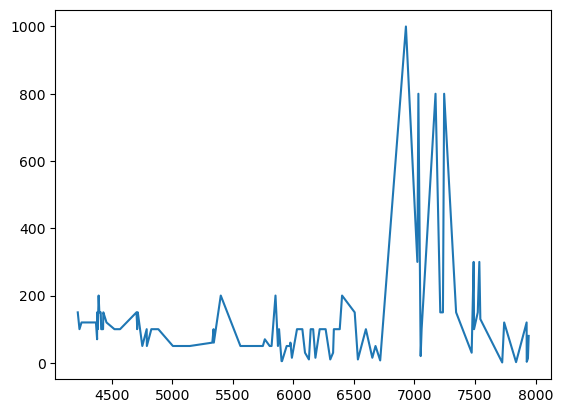

In [7]:
path = "Astrowoche2025/Ne_spec.csv"
# CSV einlesen
ref = pd.read_csv(path)

# In float konvertieren (alles Nicht-Numerische wird NaN)
ref["Wavelength (angstrom)"] = pd.to_numeric(ref["Wavelength (angstrom)"], errors="coerce")
ref["Intensity"] = pd.to_numeric(ref["Intensity"], errors="coerce")

# Zeilen mit kaputten Werten wegwerfen
ref = ref.dropna(subset=["Wavelength (angstrom)", "Intensity"])

# Jetzt erst filtern
ref = ref[(ref["Wavelength (angstrom)"] > 4000) & 
            (ref["Wavelength (angstrom)"] < 8000)]

wavelength = ref["Wavelength (angstrom)"].to_numpy(dtype=np.float64)
intensity  = ref["Intensity"].to_numpy(dtype=np.float64)

ref_w = wavelength
ref_w_diff = np.diff(ref_w)
ref_I = intensity

plt.plot(ref_w, ref_I)

# Evaluation Stars

In [8]:
def plot_spectrum(x_comb, lam_axis, s_comb, title):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

    # --- 1:  ---
    axes[0].plot(x_comb, s_comb, lw=1)
    axes[0].set_title(title)
    axes[0].set_ylabel("Flux $[$W/m$^2]$")
    axes[0].set_xlabel("Pixel")
    axes[0].grid(True, alpha=0.3)

    # --- 2: wavelength ---
    axes[1].plot(lam_axis,s_comb, lw=1 )
    # axes[1].legend()
    axes[1].set_ylabel("Flux $[$W/m$^2]$")
    axes[1].set_xlabel("Wavelength [Angstrom]")
    axes[1].grid(True, alpha=0.3)


    plt.tight_layout()
    plt.show()

## 1. Night, 1. Calibration

### Wavelength calibration

2360
831
2360
830
830 != 700


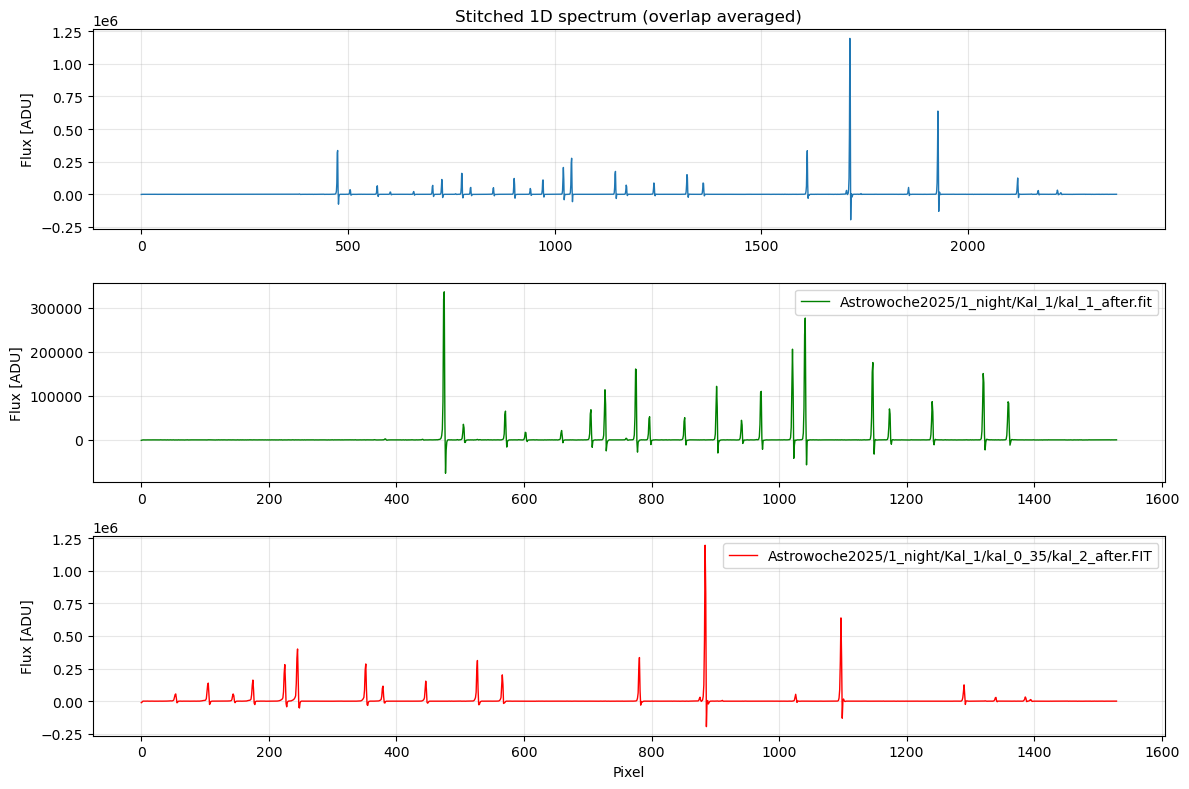

Scal: 2.0122096603041935
inliers: 10 coeff: [4.26142174e-01 5.60203207e+03]


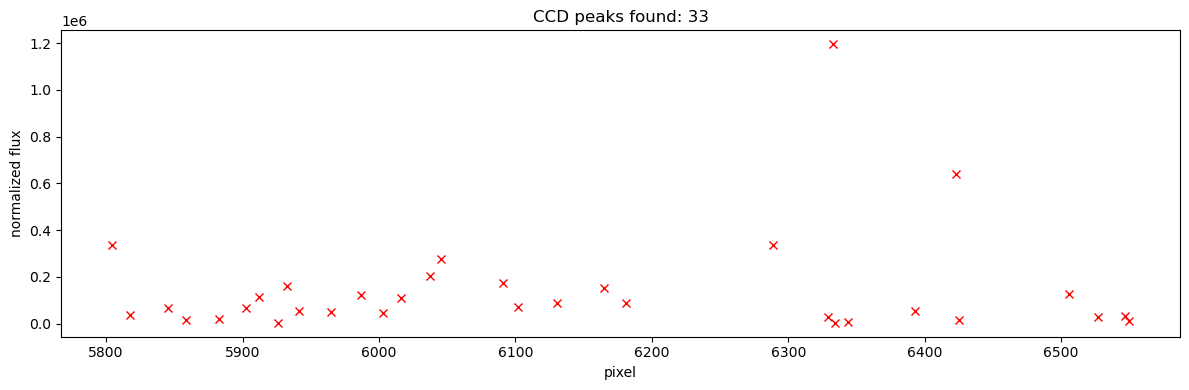

[5804.4496     5817.23386522 5845.3592487  5858.56965609 5882.85976
 5902.4623     5911.83742783 5925.90011957 5932.29225217 5941.66738
 5965.10519957 5986.41230826 6003.03185304 6016.24226043 6037.12322696
 6045.64607043 6090.81714087 6101.89683739 6130.44836304 6164.53973696
 6181.15928174 6288.54710957 6329.03061609 6332.43975348 6334.14432217
 6343.94559217 6392.95194217 6423.20803652 6424.91260522 6505.45347609
 6526.76058478 6546.36312478 6549.77226217]


In [33]:

path1 = "Astrowoche2025/1_night/Kal_1/kal_1_after.fit"
path2 = "Astrowoche2025/1_night/Kal_1/kal_0_35/kal_2_after.FIT"
x_comb, s_comb, shift, x1, s1, x2, s2, scal = combine_spec(path1, path2, plot = True, shift = -700)

print("Scal:", scal)

ninl, coeff = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff)

lam_axis = np.polyval(coeff, x_comb)
peaks, props = find_peaks(s_comb,height = 3000)
plt.figure(figsize=(12,4))
plt.plot(lam_axis[peaks] ,s_comb[peaks],  "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])


In [ ]:


peaks, props = find_peaks(s_comb,height = 3000)


plt.figure(figsize=(12,4))
plt.plot(x_comb, s_comb, lw=1)
plt.plot(x1, s1, "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,4))
plt.plot(x_comb, s_comb, lw=1)
plt.plot(x_comb[peaks], s_comb[peaks], "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()


coeffs = calibrate_wavelength(x_comb, s_comb)
print(shift)


inliers: 12 coeff: [9.67306308e-01 5.39398471e+03]


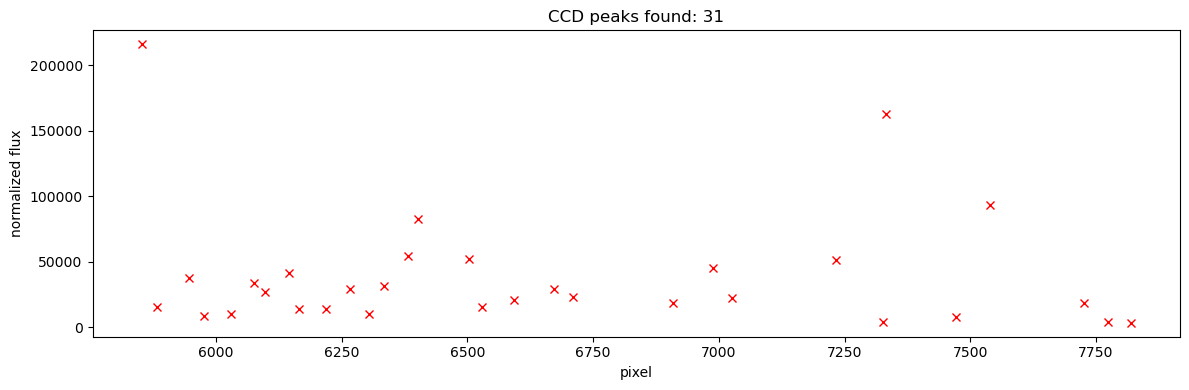

[5852.4879     5882.47439556 5945.34930561 5976.30310748 6030.47226075
 6074.96835093 6097.21639603 6144.61440514 6164.92783762 6218.12968458
 6266.495      6304.21994603 6334.20644159 6381.6044507  6400.95057687
 6503.48504556 6528.63500958 6593.44453224 6671.79634322 6709.52128925
 6909.75369509 6988.10550607 7025.8304521  7233.80130841 7325.69540771
 7333.43385818 7470.79135397 7539.47010187 7726.16021939 7774.52553481
 7819.021625  ]


In [184]:
ninl, coeff = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff)

lam_axis = np.polyval(coeff, x_comb)

# print(ref_w)
# print(len(ref_w))
# print(len(peaks))
plt.figure(figsize=(12,4))
# plt.plot(x_comb, s_comb, lw=1)
plt.plot(lam_axis[peaks] ,s_comb[peaks],  "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])


### Rigel

Astrowoche2025/1_night/Kal_1/Rigel_2\rigel_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_1/Rigel_2\rigel_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_1/Rigel_2\rigel_spec_2_backup_2.FIT
1530
shift: [-156.04]
2904
1375
2904
1374
1374 != 156


C:\Users\hausa\AppData\Local\Temp\ipykernel_8260\3204784137.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25


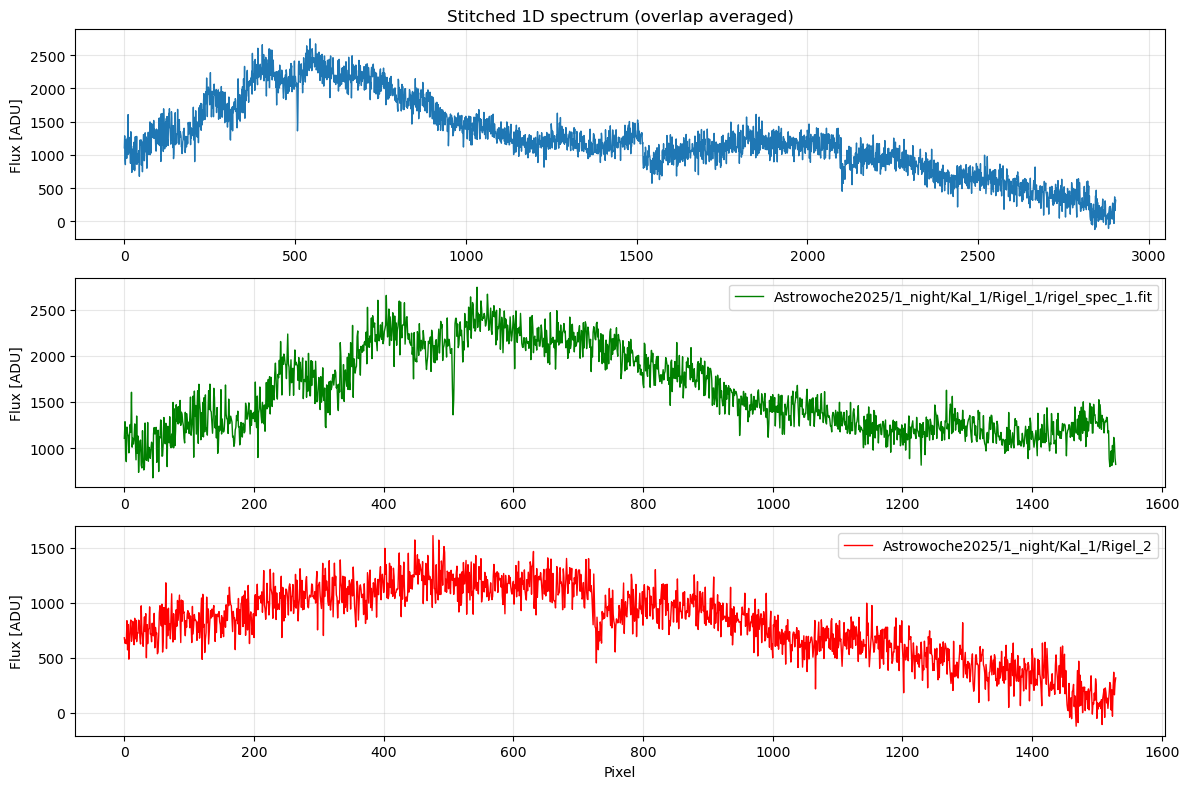

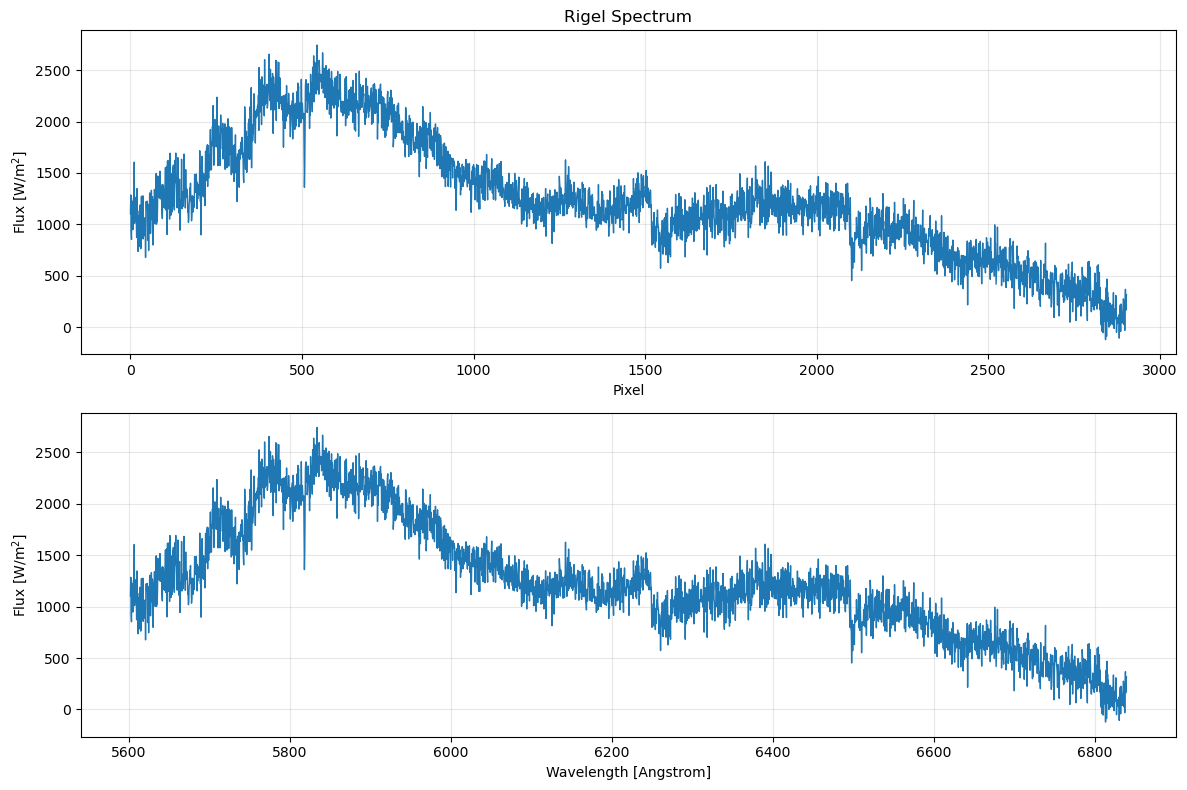

In [ ]:
path1 = "Astrowoche2025/1_night/Kal_1/Rigel_1/rigel_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/Rigel_2"


x_comb_rigel, s_comb_rigel, *rest = combine_spec(path1, path2, folder2 =True, plot = True, scal = scal)
lam_axis_rigel = np.polyval(coeff, x_comb_rigel)
plot_spectrum(x_comb_rigel, lam_axis_rigel, s_comb_rigel, "Rigel Spectrum")

### Capella

Astrowoche2025/1_night/Kal_1/Capella_2\capella_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_1/Capella_2\capella_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_1/Capella_2\capella_spec_2_backup_2.FIT
1530
shift: [-0.04]
3060
3060
1530
1530
1530
1530
1530 != 0


C:\Users\hausa\AppData\Local\Temp\ipykernel_8260\4069382060.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25


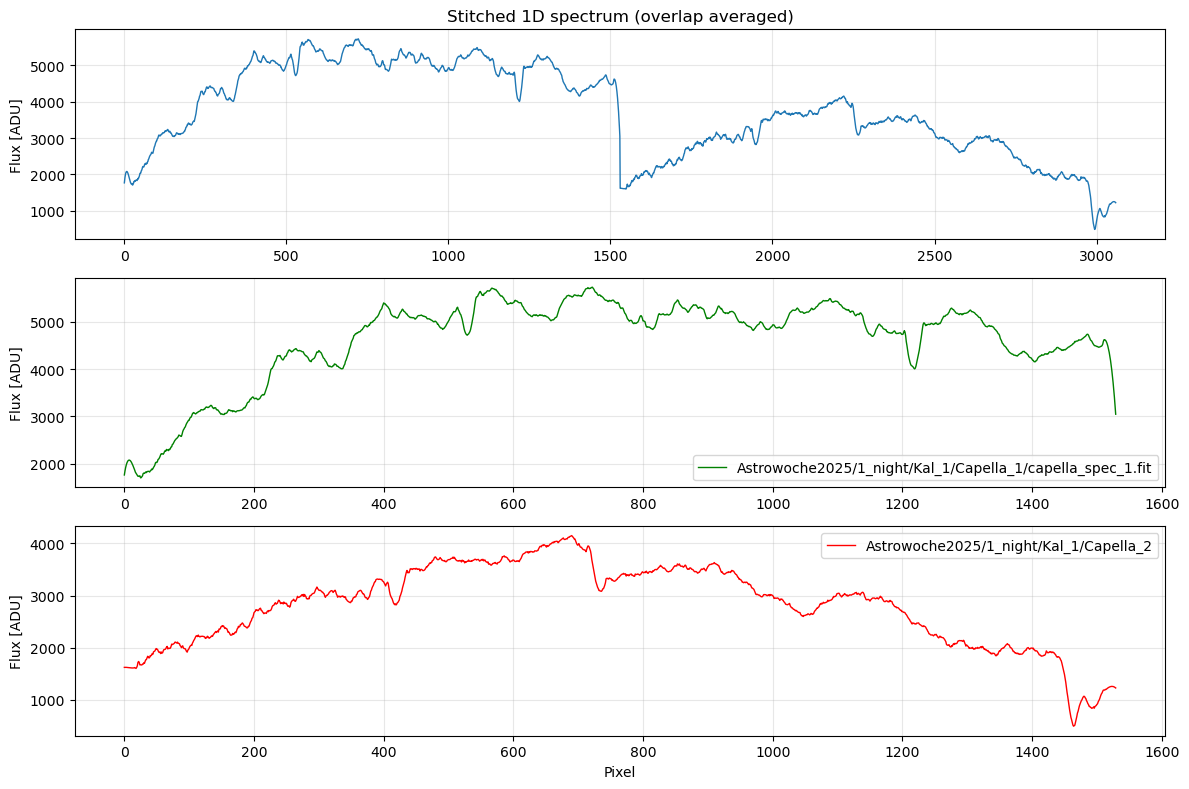

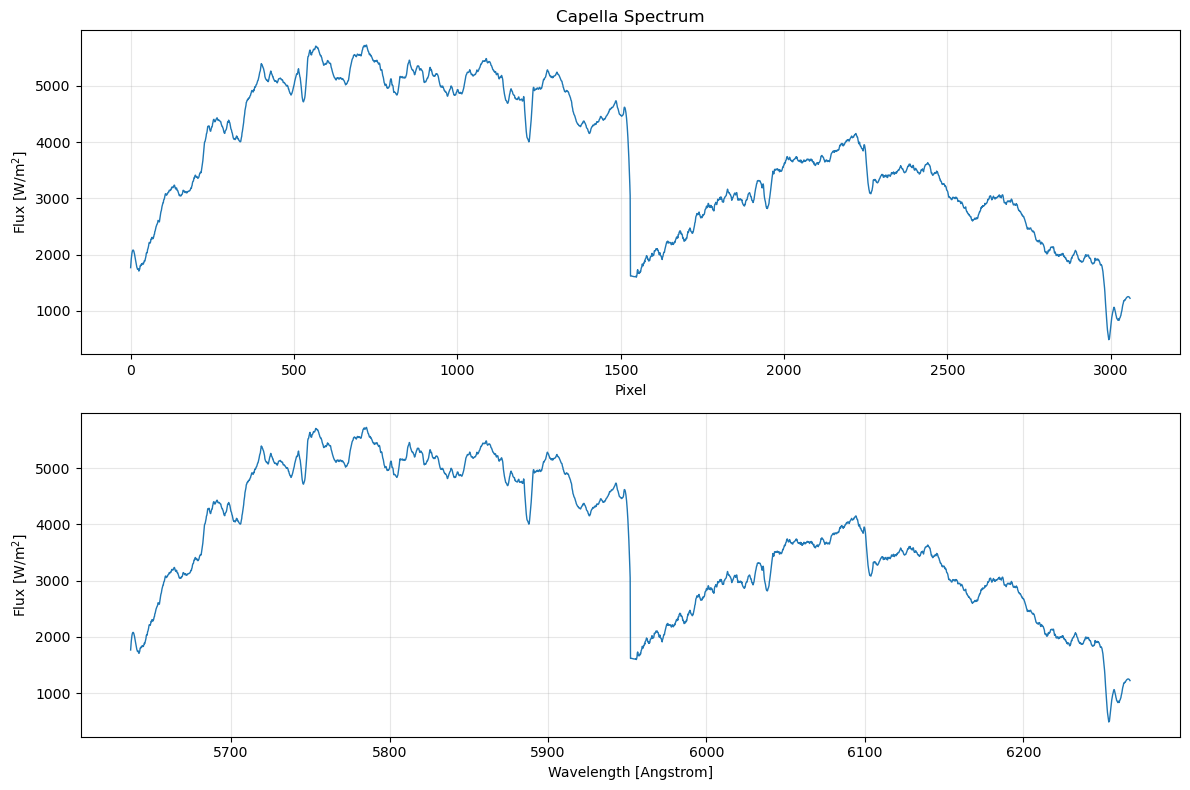

In [66]:
path1 = "Astrowoche2025/1_night/Kal_1/Capella_1/capella_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/Capella_2"

x_comb_capella, s_comb_capella, *rest = combine_spec(path1, path2, folder2=True, plot = True, scal = scal, filtering = True)
lam_axis_capella = np.polyval(coeff, x_comb_capella)
plot_spectrum(x_comb_capella, lam_axis_capella, s_comb_capella, "Capella Spectrum")

### Mirfak

Astrowoche2025/1_night/Kal_1/mirfak_2\mirfak_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_1/mirfak_2\mirfak_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_1/mirfak_2\mirfak_spec_2_backup_2.FIT
1530
shift: [304.92]
2756
2756
1226
1226
1226
1226
1226 != 304


C:\Users\hausa\AppData\Local\Temp\ipykernel_8260\3204784137.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25


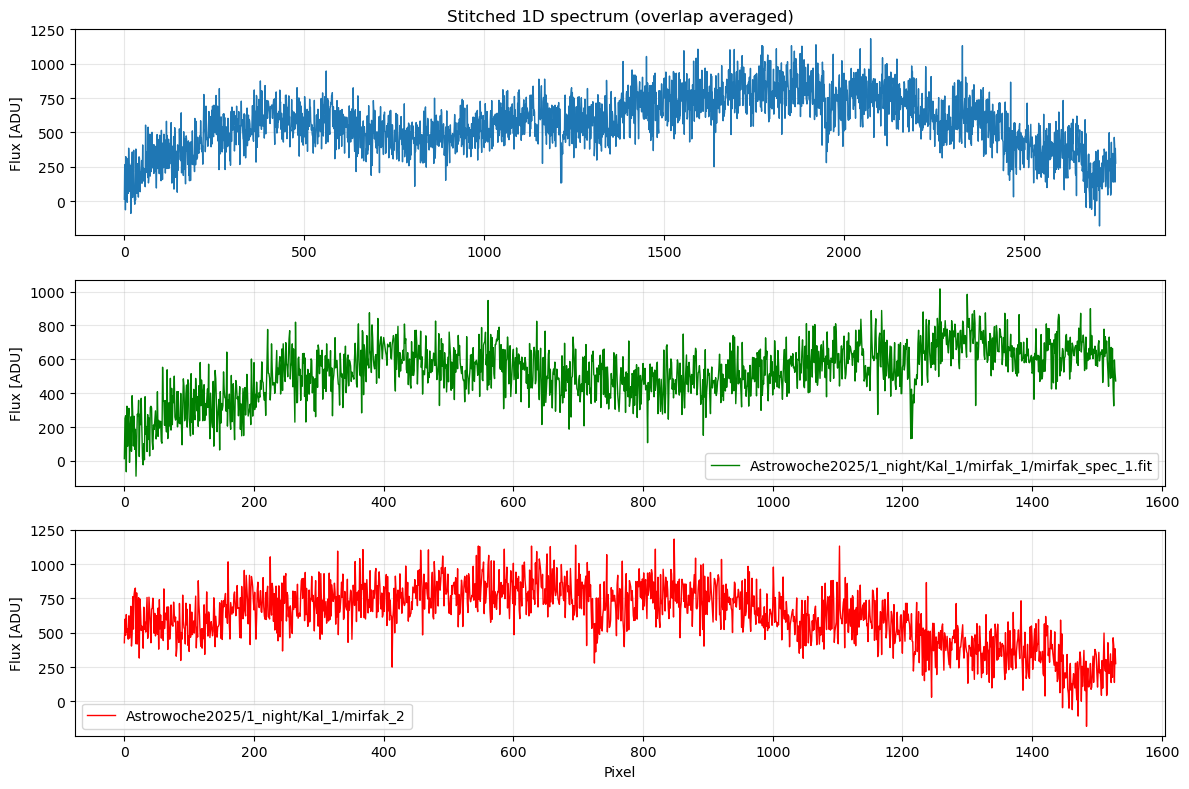

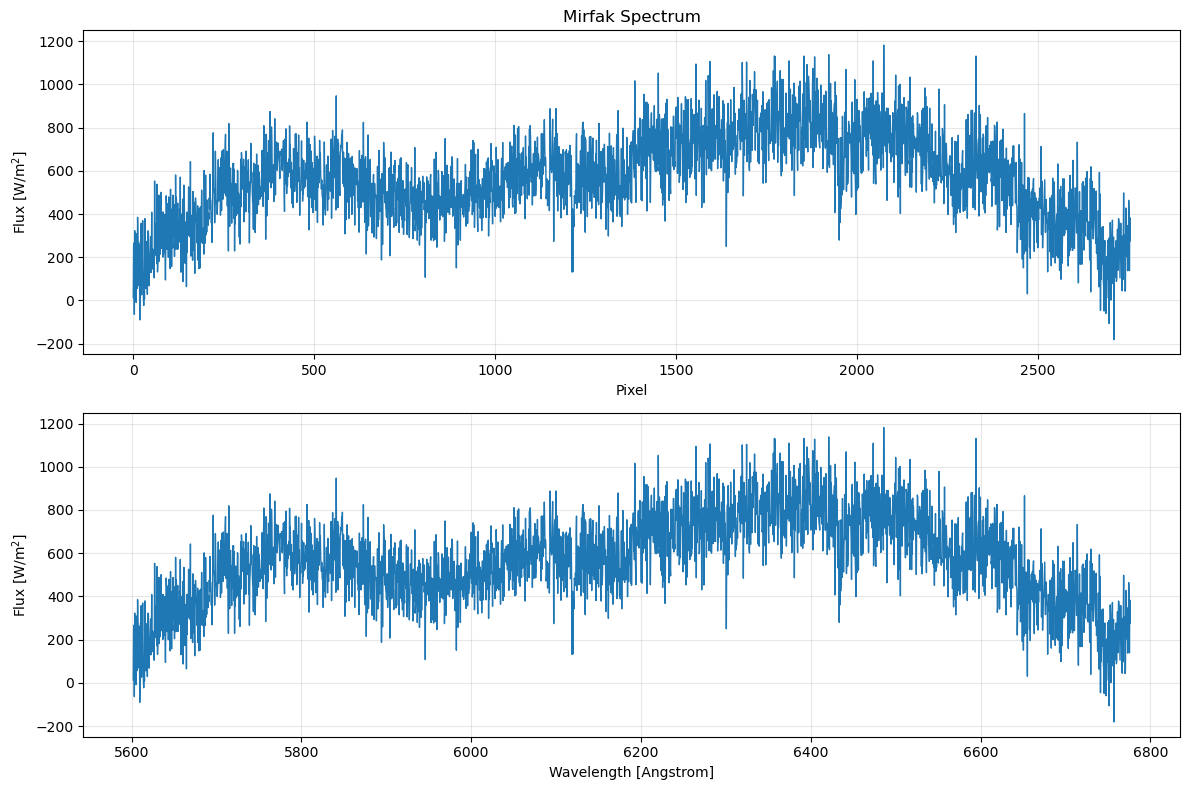

In [43]:
path1 = "Astrowoche2025/1_night/Kal_1/mirfak_1/mirfak_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/mirfak_2"

x_comb_mirfak, s_comb_mirfak, *rest = combine_spec(path1, path2, folder2=True, plot = True, scal = scal)
lam_axis_mirfak = np.polyval(coeff, x_comb_mirfak)
plot_spectrum(x_comb_mirfak, lam_axis_mirfak, s_comb_mirfak, "Mirfak Spectrum")

### Pollux

Astrowoche2025/1_night/Kal_1/pollux_2\pollux_spec_2.FIT
shift: [415.96]
2645
2645
1115
1115
1115
1115
1115 != 415


C:\Users\hausa\AppData\Local\Temp\ipykernel_13080\3104047234.py:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25


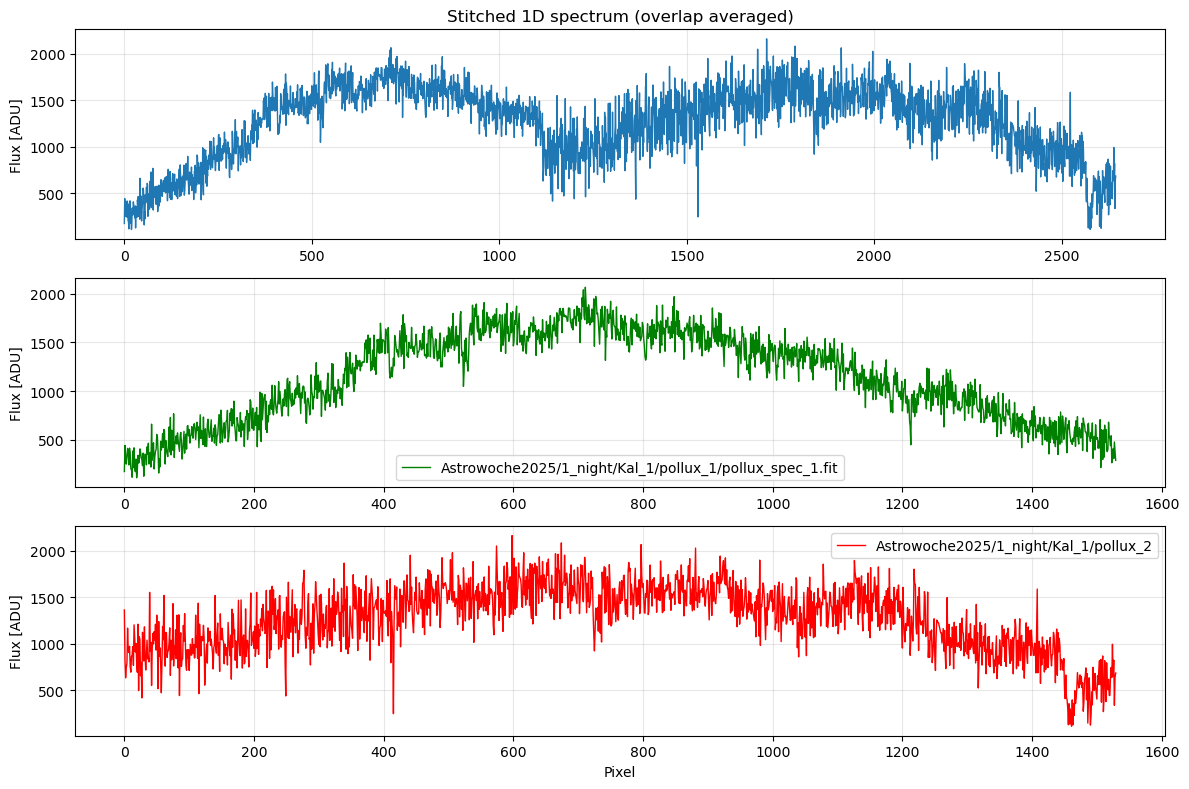

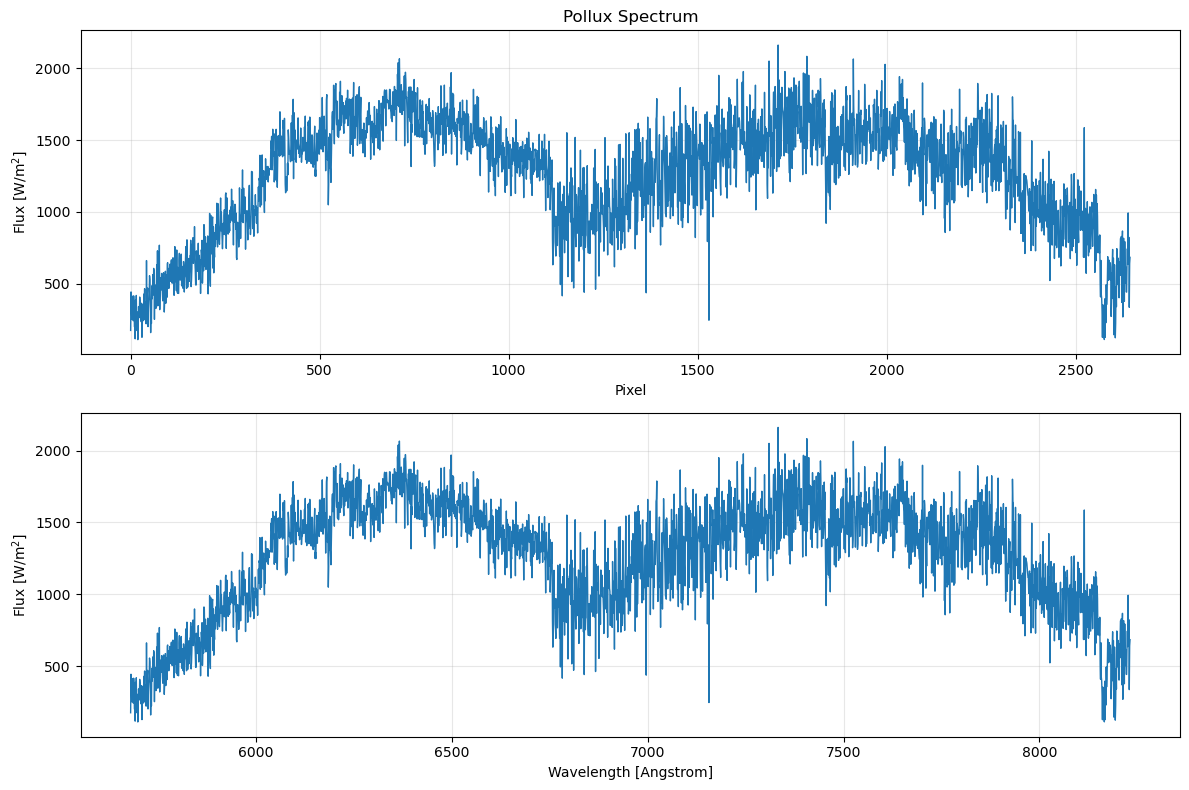

In [239]:
path1 = "Astrowoche2025/1_night/Kal_1/pollux_1/pollux_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/pollux_2"

x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder2=True, plot = True)
lam_axis_pollux = np.polyval(coeff, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Pollux Spectrum")

## 1. Night second round

### calibration

Astrowoche2025/1_night/Kal_2/kal_1_25\kal_1_25.FIT
1530
Astrowoche2025/1_night/Kal_2/kal_1_25\kal_1_25_after.FIT
1530
Astrowoche2025/1_night/Kal_2/kal_0_35\kal_0_35.FIT
1530
Astrowoche2025/1_night/Kal_2/kal_0_35\kal_0_35_after.FIT
1530
2260
731
2260
730
730 != 800


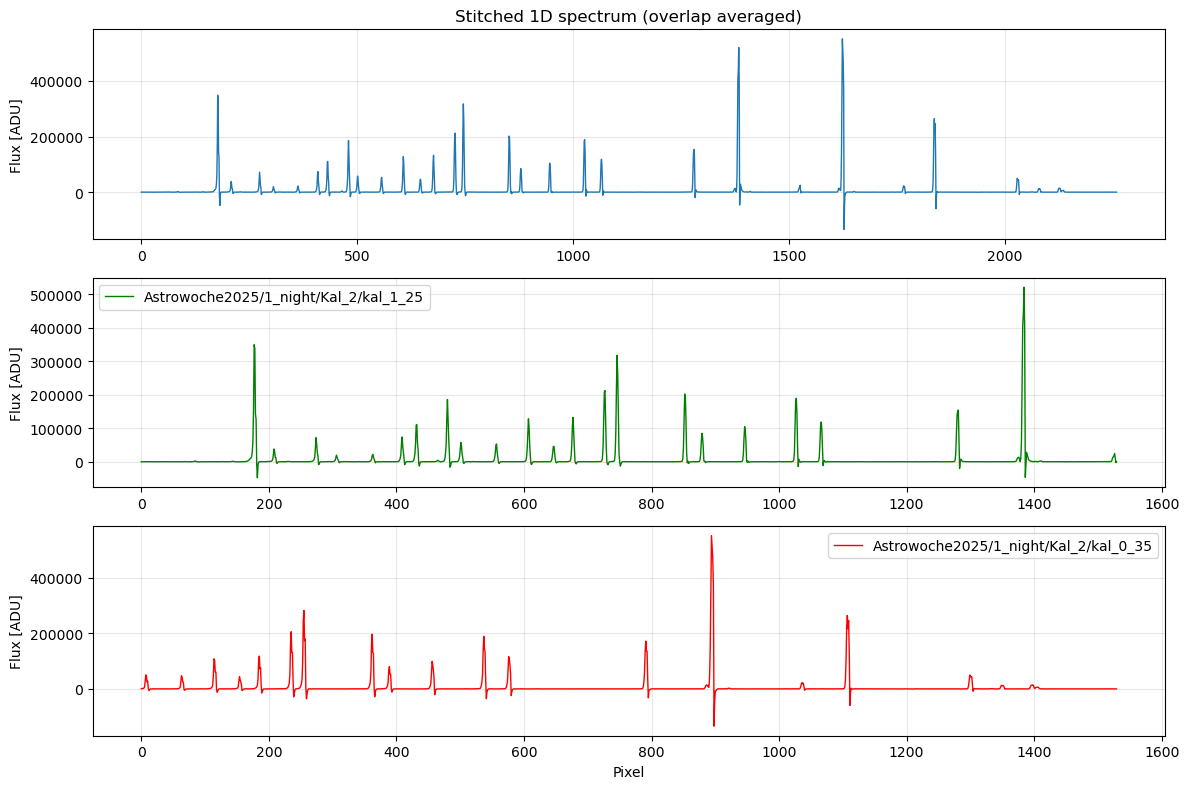

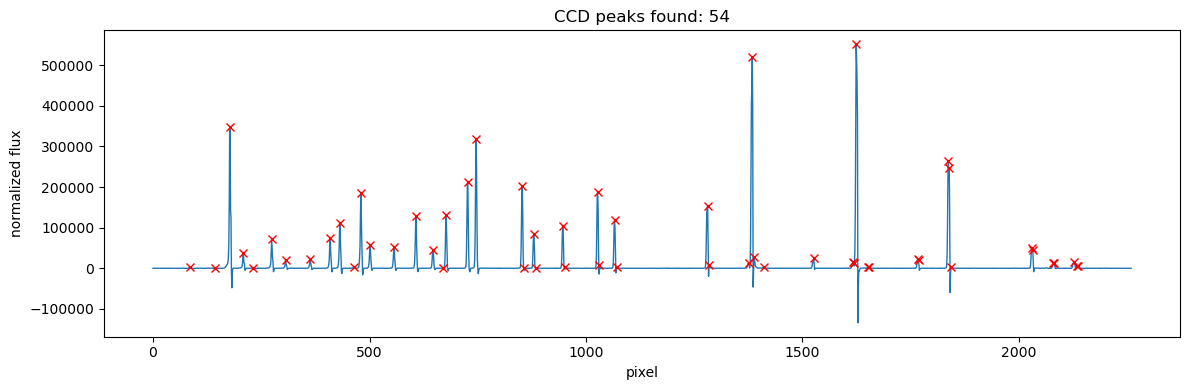

inliers: 11 coeff: [9.69571663e-01 5.39194136e+03]


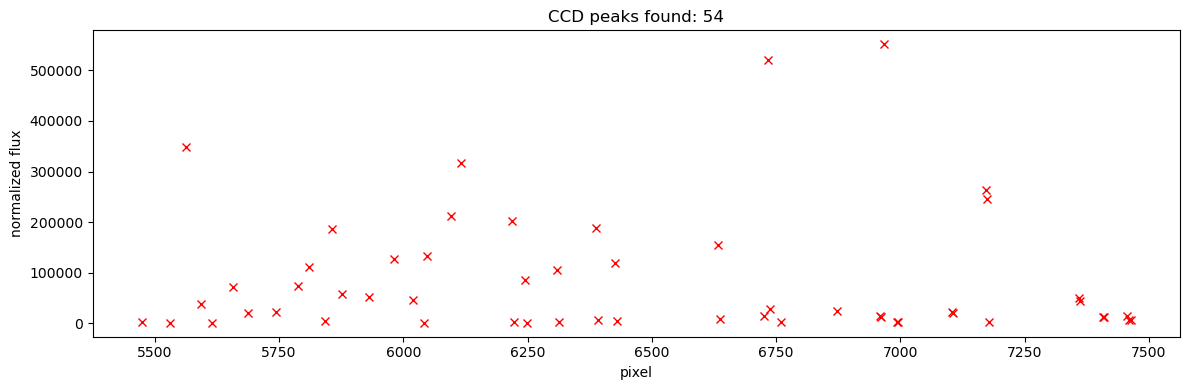

[5474.35495152 5530.59010796 5563.5555445  5593.61226604 5614.94284262
 5657.60399578 5688.63028899 5743.89587377 5788.49617026 5810.7963185
 5842.79218337 5857.33575831 5877.69676323 5931.99277635 5980.47135948
 6019.254226   6041.55437424 6048.34137588 6096.81995902 6115.24182061
 6218.01641686 6222.86427518 6244.19485176 6249.04271007 6309.15615316
 6314.00401148 6387.69145785 6391.5697445  6425.50475269 6430.35261101
 6633.96266019 6637.84094684 6726.07196815 6733.82854145 6737.7068281
 6760.00697635 6871.50771756 6958.76916721 6960.70831054 6966.52574052
 6992.70417541 6994.64331874 7104.20491663 7106.14405995 7173.04450468
 7174.98364801 7178.86193466 7359.20226393 7362.11097892 7407.68084707
 7409.6199904  7455.18985855 7460.03771686 7462.94643185]


In [260]:

path1 = "Astrowoche2025/1_night/Kal_2/kal_1_25"
path2 = "Astrowoche2025/1_night/Kal_2/kal_0_35"
x_comb, s_comb, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, shift = -800)


peaks, props = find_peaks(s_comb,height = 1000)


plt.figure(figsize=(12,4))
plt.plot(x_comb, s_comb, lw=1)
plt.plot(x_comb[peaks], s_comb[peaks], "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

n_iff, coeff_night1_2 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)

ninl, coeff_night1_2 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff)

lam_axis = np.polyval(coeff, x_comb)


plt.figure(figsize=(12,4))
# plt.plot(x_comb, s_comb, lw=1)
plt.plot(lam_axis[peaks] ,s_comb[peaks],  "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])


### Betelgeuse

shift: [-488.96]
2572
1043
2572
1042
1042 != 488


C:\Users\hausa\AppData\Local\Temp\ipykernel_13080\4133966404.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25


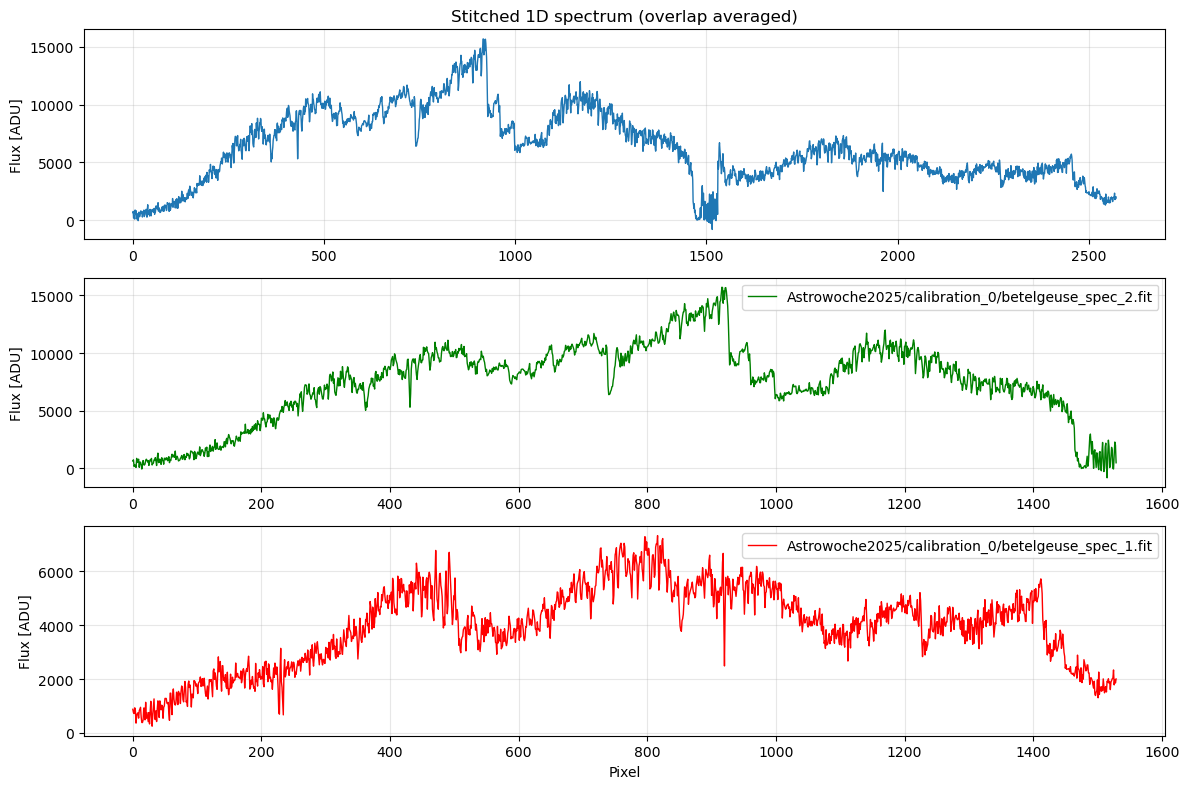

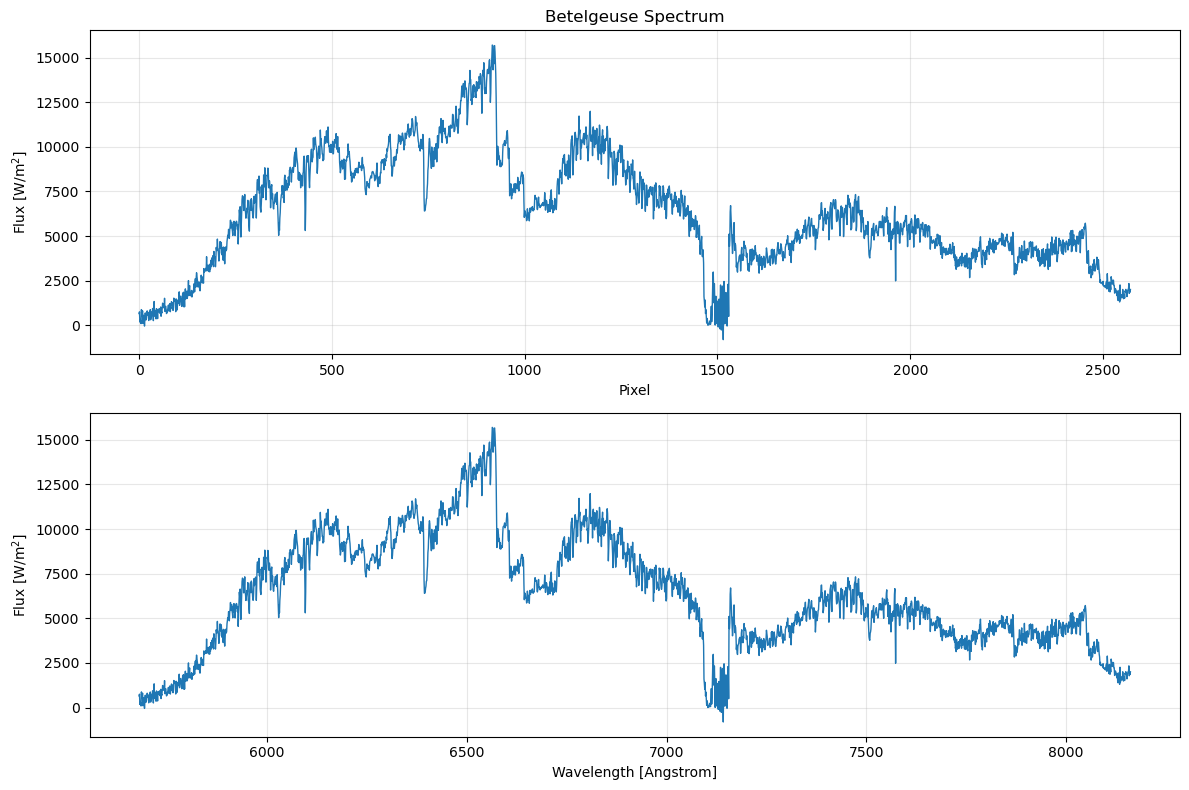

In [ ]:
path1 = "Astrowoche2025/2_night/Kal_1/pollux_1/pollux_spec_1.fit"
path2 = "Astrowoche2025/2_night/Kal_1/pollux_2"

x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder2=True, plot = True)
lam_axis_pollux = np.polyval(coeff, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Pollux Spectrum")


path1 = "Astrowoche2025/calibration_0/betelgeuse_spec_2.fit"
path2 = "Astrowoche2025/calibration_0/betelgeuse_spec_1.fit"

# path1 = "Astrowoche2025/calibration_0/kal_2_25.fit"
# path2 = "Astrowoche2025/calibration_0/kal_0_35.fit"

x_comb_betelgeuse, s_comb_betelgeuse, *rest = combine_spec(path1, path2, plot = True)
lam_axis_betelgeuse = np.polyval(coeff_night1_2, x_comb_betelgeuse)
plot_spectrum(x_comb_betelgeuse, lam_axis_betelgeuse, s_comb_betelgeuse, "Betelgeuse Spectrum")

### Bellatrix

shift: [75.12]
2985
2985
1455
1455
1455
1455
1455 != 75


C:\Users\hausa\AppData\Local\Temp\ipykernel_13080\4133966404.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25


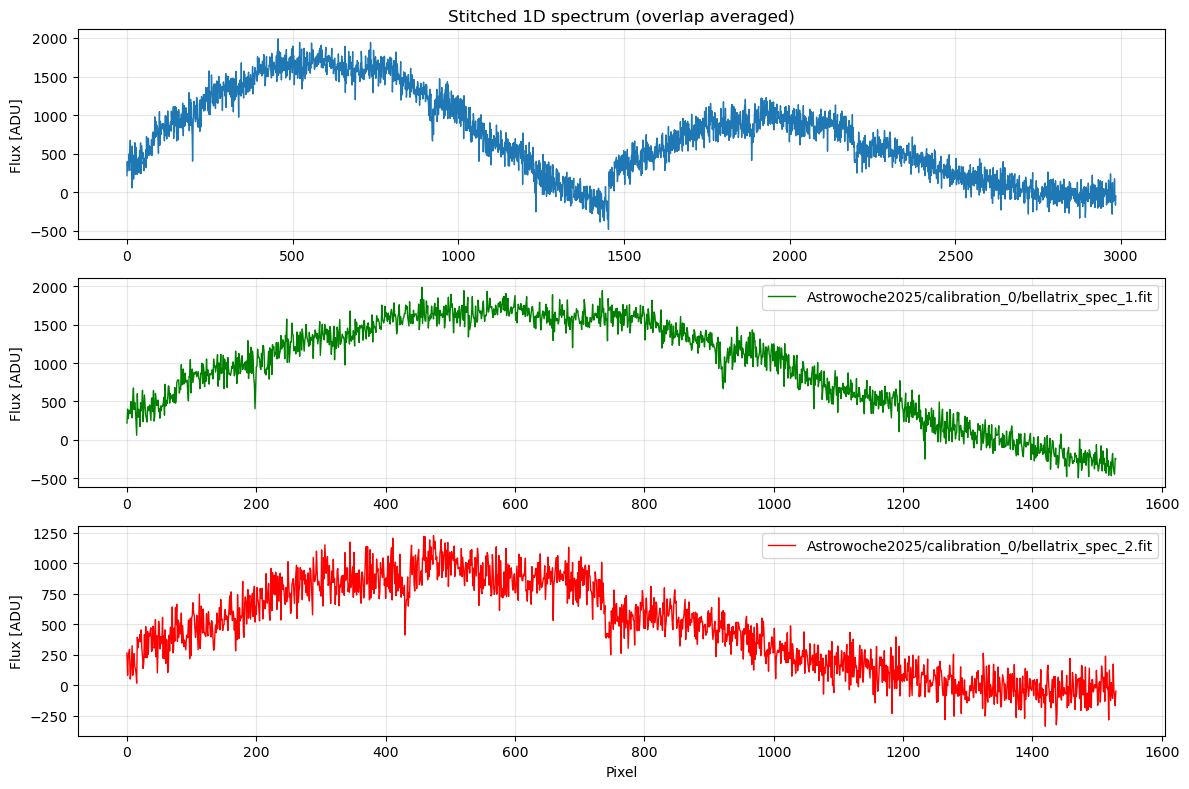

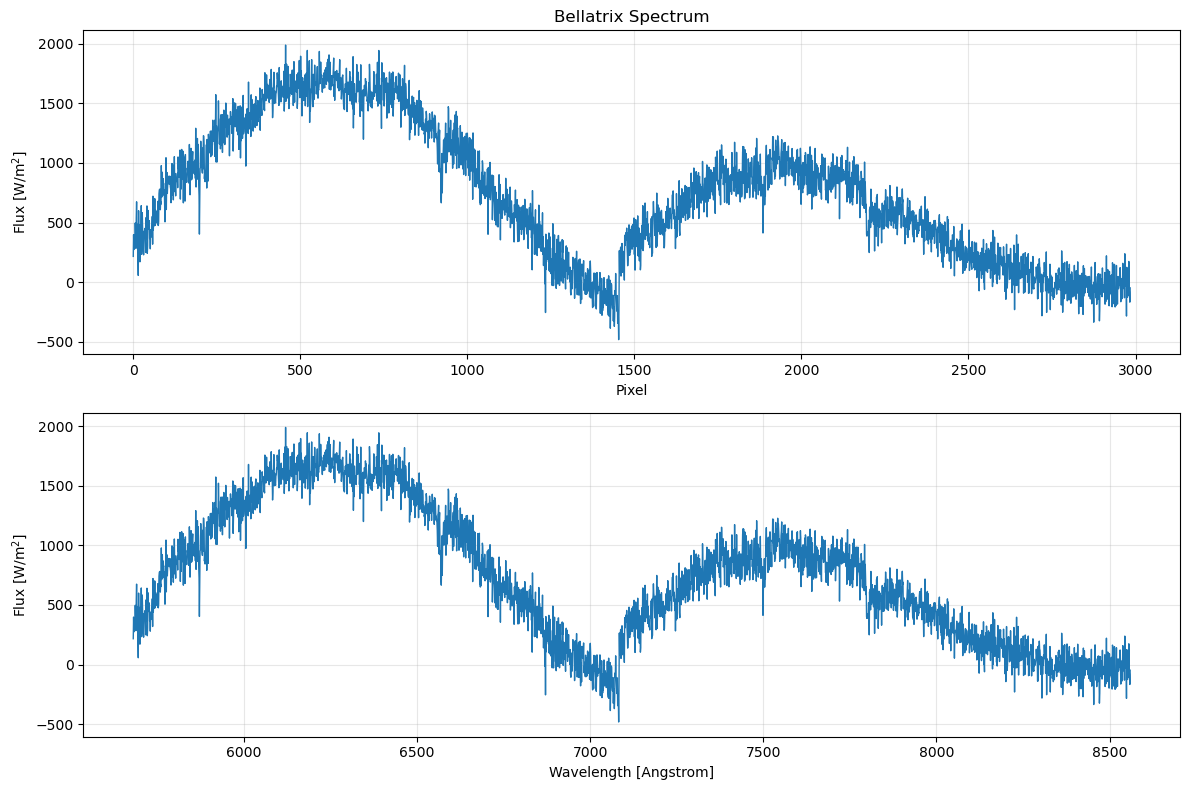

In [201]:
path1 = "Astrowoche2025/calibration_0/bellatrix_spec_1.fit"
path2 = "Astrowoche2025/calibration_0/bellatrix_spec_2.fit"

# path1 = "Astrowoche2025/calibration_0/kal_2_25.fit"
# path2 = "Astrowoche2025/calibration_0/kal_0_35.fit"

x_comb_bellatrix, s_comb_bellatrix, *rest = combine_spec(path1, path2, plot = True)
lam_axis_bellatrix = np.polyval(coeff_night1_2, x_comb_bellatrix)
plot_spectrum(x_comb_bellatrix, lam_axis_bellatrix, s_comb_bellatrix, "Bellatrix Spectrum")

## 2. Night

## 2. Night first round

# 3. Night

## 1. round

Scal:  0.38983259667791814
2660
2660
1130
1130
1130
1130
1130 != 400


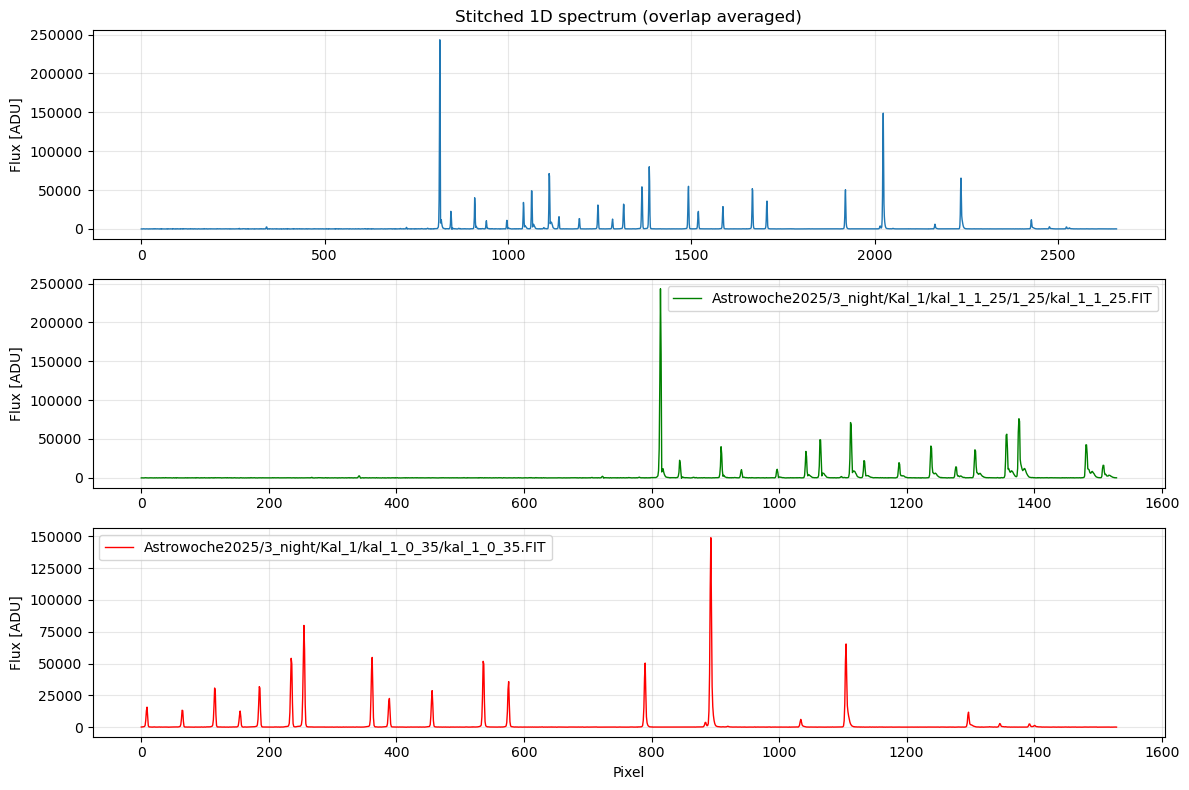

inliers: 11 coeff: [2.06172961e-01 5.63662481e+03]


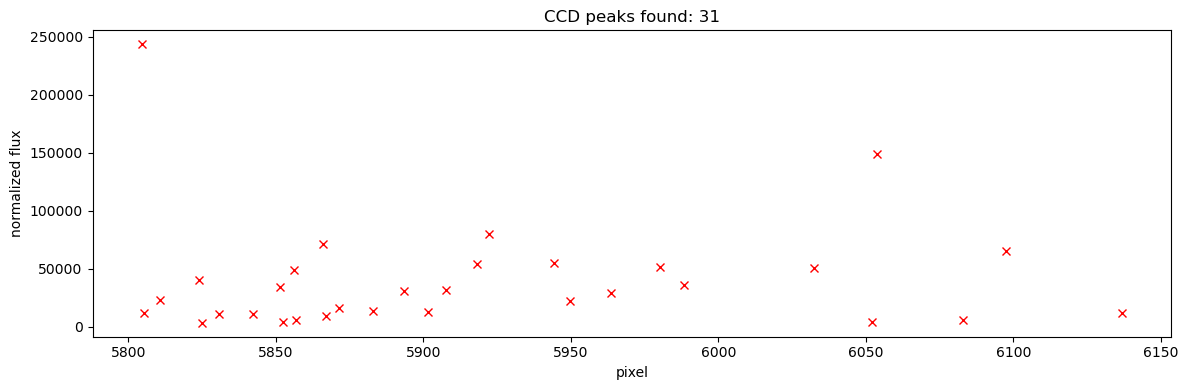

[5804.4496     5805.27429185 5810.63478884 5824.03603133 5824.86072318
 5830.63356609 5842.17925193 5851.45703519 5852.4879     5855.99284034
 5856.81753219 5865.88914249 5866.9200073  5871.45581245 5882.79532532
 5893.31014635 5901.55706481 5907.74225365 5918.05090172 5922.17436094
 5944.23486781 5949.80153777 5963.61512618 5980.10896309 5988.35588155
 6032.47689528 6052.06332661 6053.7127103  6082.78309785 6097.42137811
 6137.0065867 ]


In [58]:
path1 = "Astrowoche2025/3_night/Kal_1/kal_1_1_25/1_25/kal_1_1_25.FIT"
path2 = "Astrowoche2025/3_night/Kal_1/kal_1_0_35/kal_1_0_35.FIT"

x_comb, s_comb, shift, x1, s1, x2, s2, scal_night3_1 = combine_spec(path1, path2, folder1=False, folder2 = False , plot = True, shift = 400)




ninl, coeff_night3_1 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff_night3_1)

lam_axis = np.polyval(coeff, x_comb)
peaks, props = find_peaks(s_comb,height = 3000)
plt.figure(figsize=(12,4))
plt.plot(lam_axis[peaks] ,s_comb[peaks],  "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])

## Vega

Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1_backup.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1_backup_2.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2_backup.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2_backup_2.FIT
1530
shift: [-0.02]
3060
3060
1530
1530
1530
1530
1530 != 0


C:\Users\hausa\AppData\Local\Temp\ipykernel_8260\3414966000.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25


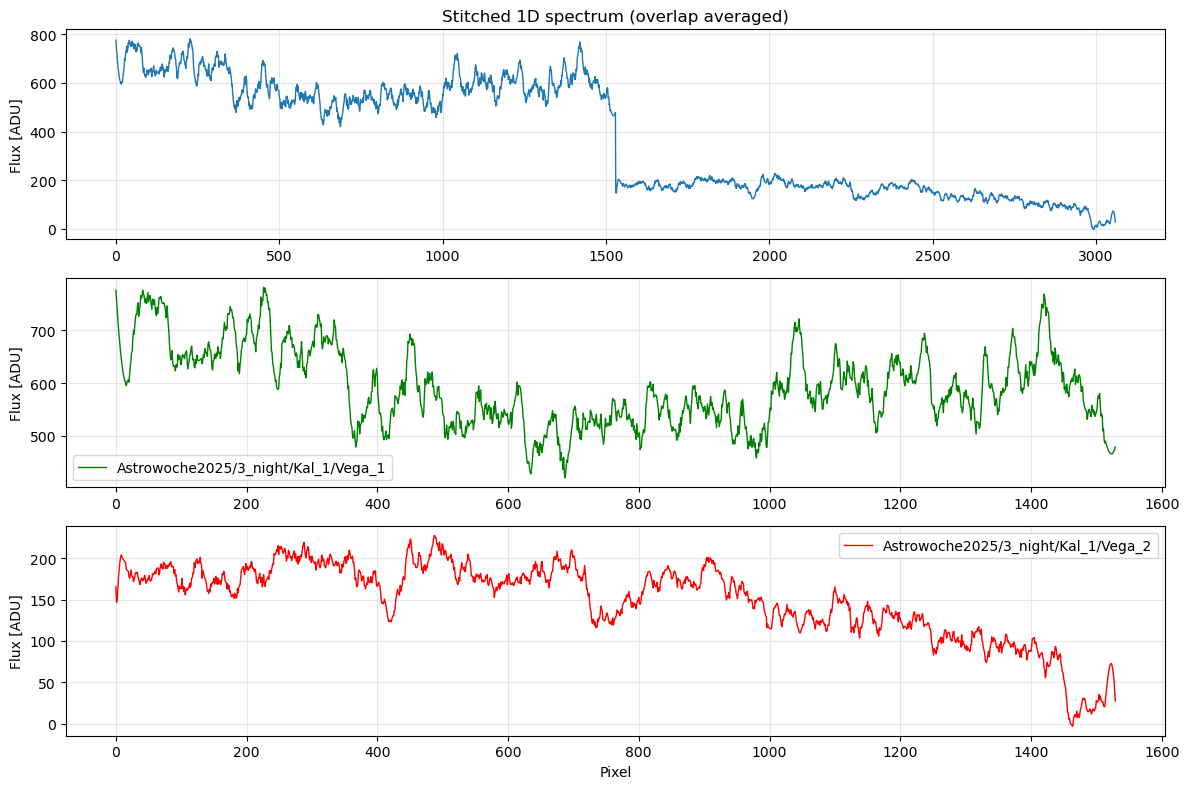

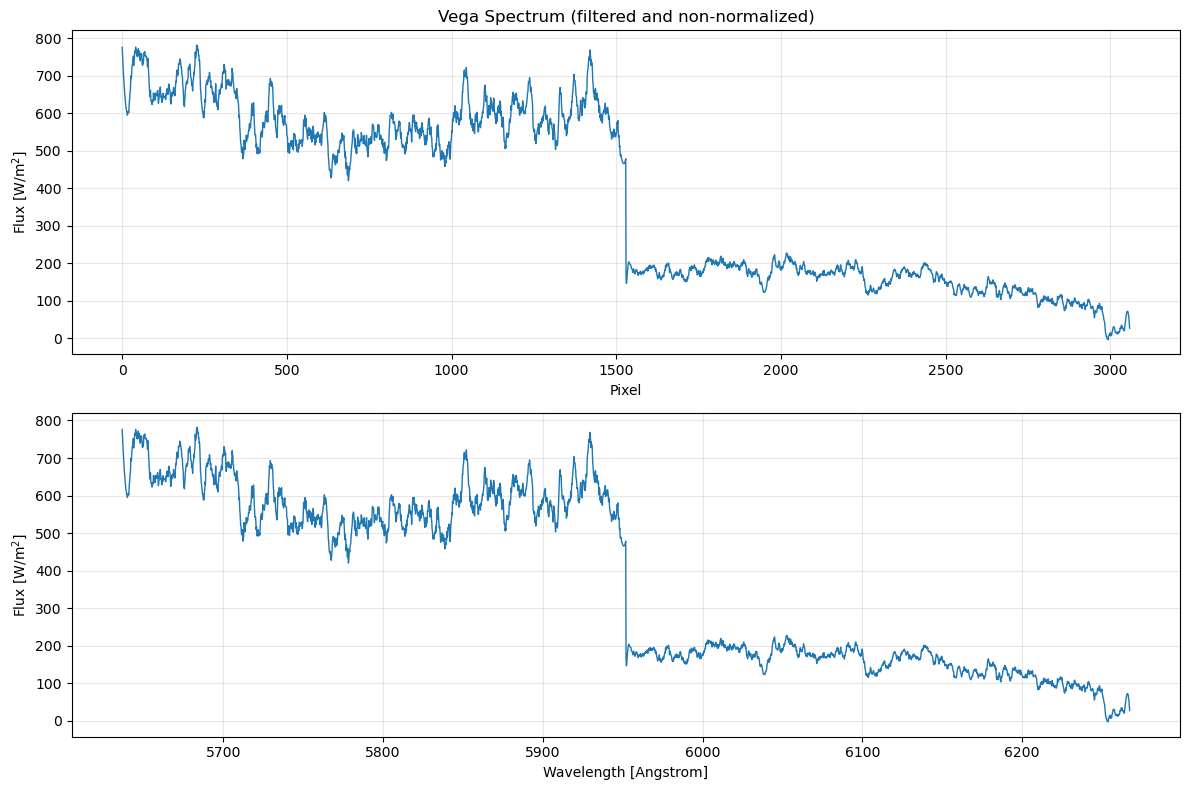

In [84]:
path1 = "Astrowoche2025/3_night/Kal_1/Vega_1"
path2 = "Astrowoche2025/3_night/Kal_1/Vega_2"


x_comb_vega, s_comb_vega, *rest = combine_spec(path1, path2,folder1= True,  folder2 =True,  plot = True, scal = scal_night3_1, filtering = True, normalize = False)
lam_axis_vega = np.polyval(coeff_night3_1, x_comb_vega)
plot_spectrum(x_comb_vega, lam_axis_vega, s_comb_vega, "Vega Spectrum (filtered and non-normalized)")